<a href="https://colab.research.google.com/github/TharindaDilshan/Coursera_Capstone/blob/main/Capstone%20Project/Paris_Tour_Guide_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Paris Tour Guide**

## Exploring the City of Light


---


### **1. Introduction**
Paris is a popular tourist destination for all types of tourists and it is also called the City of Lights. The city attracts millions of tourists every year and it features grandiose monuments such as Arc de Triomphe, Eiffel Tower, and so on. The city has a romantic charm and it is filled with a plethora of activities that you can try out.

### **2. Business Problem**
The intention of this project is to help tourists explore Paris depending on the experiences the neighborhoods in Paris has to offer. This project can later be extended in the future to generalize results, so that it is possible for tourists to get details about other interesting tourist destinations as well.

### **3. Data Description**
The neighborhoods, boroughs, and venues are derived using the postal codes of Paris.

Data source: https://www.data.gouv.fr/fr/datasets/r/e88c6fda-1d09-42a0-a069-606d3259114e

The above source contains data related to all the neighborhoods in France. For the purpose of this project, only neighborhoods in Paris will be considered for now.

The source returns a JSON file that contains the following data,

* postal_code : Postal codes for France
* nom_comm : Neighbourhoods in France
* nom_dept : Boroughs(towns)
* geo_point_2d : latitude and longitude tuple of the Neighbourhoods

### 3.1 Foursquare API Usage
Foursquare API will be used to retrieve data related to venues in different neighborhoods. For each neighborhood, related venues and tourist attractions that are within the radius will be identified using the foursquare API.

The final dataframe created after processing the information obtained through the foursquare API are as follows,

* Neighbourhood
* Neighborhood latitude and Longitude
* Name of the venue
* Venue latitude and longitude
* Venue category


### **4. Implementation**

Importing required Python Libraries


```
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests
import folium
from sklearn.cluster import KMeans
```



### 4.1 Data Collection and Preprocessing

Data is collected using a french government website. As the dataset contains details about France, it should be preprocessed and filtered to get the Paris data. Pandas is used to read data.

```
!wget -q -O 'france.json' https://www.data.gouv.fr/fr/datasets/r/e88c6fda-1d09-42a0-a069-606d3259114e

france_data = pd.read_json('france.json')
france_data.head()
```
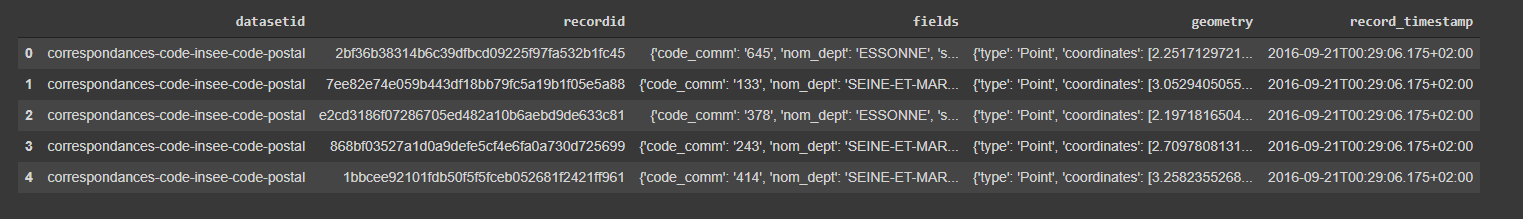



Initially, a dataframe is created using the data

```
france_dataframe = pd.DataFrame()
for field in france_data.fields:
    field_dict = field
    france_dataframe = france_dataframe.append(field_dict, ignore_index=True)

france_dataframe.head()
```
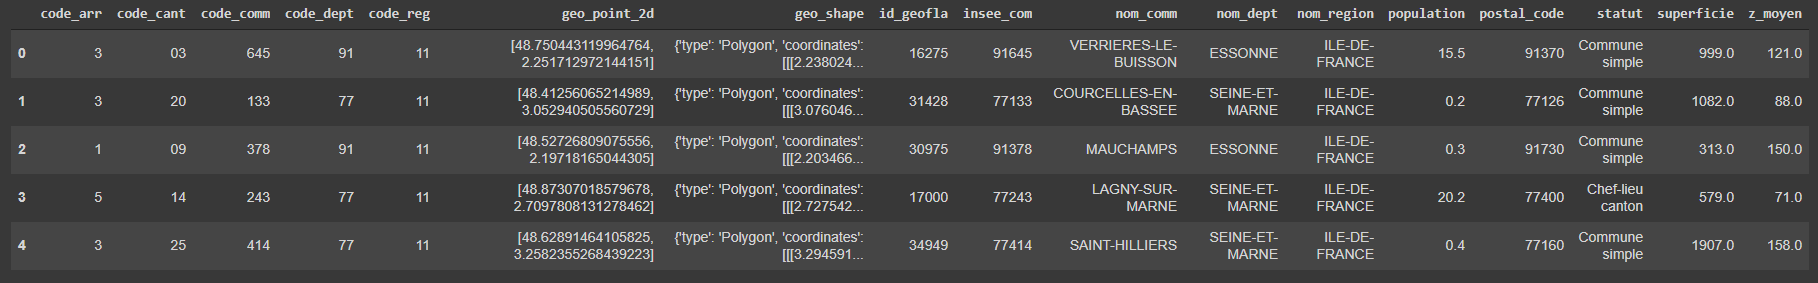


Then the dataframe is filtered to get Paris data, and only the necessary columns for our analysis.

```
df = france_dataframe[['postal_code','nom_comm','nom_dept','geo_point_2d']]

df = df[df['nom_dept'].str.contains('PARIS')].reset_index(drop=True)
df.head()
```

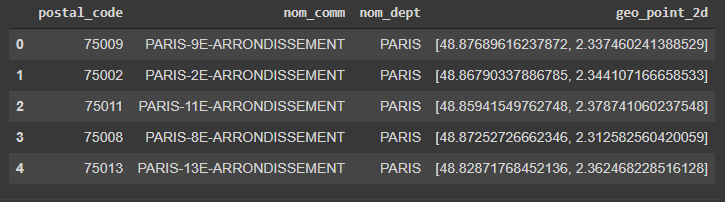



Final part of data preprocessing is to modify the Paris dataframe and separate Latitude and Longitudes into two columns


```
lat_lng = df['geo_point_2d'].astype('str')

# Process latitudes
lat = lat_lng.apply(lambda x: x.split(',')[0])
lat = lat.apply(lambda x: x.lstrip('['))

df_lat  = pd.DataFrame(lat.astype(float))
df_lat.columns=['Latitude']

# Process longitudes
lng = lat_lng.apply(lambda x: x.split(',')[1])
lng = lng.apply(lambda x: x.rstrip(']'))

df_lng = pd.DataFrame(lng.astype(float))
df_lng.columns=['Longitude']

# Combine columns
df = pd.concat([df.drop('geo_point_2d', axis=1), df_lat, df_lng], axis=1)
df.head()
```

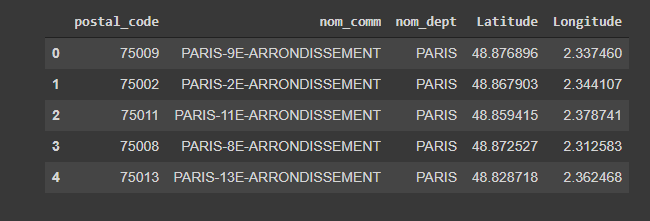



We can visualize the map of Paris along with neighborhood data that we collected using the *Folium* package


```
import geocoder

# paris = geocode(address='Paris, France, FR')[0]
paris = geocoder.arcgis('Paris, France, FR')
paris_lat = paris.json['lat']
paris_lng = paris.json['lng']

map = folium.Map(location=[paris_lat, paris_lng], zoom_start=12)
map

# adding markers to map
for latitude, longitude, borough, town in zip(df['Latitude'], df['Longitude'], df['nom_comm'], df['nom_dept']):
    label = '{}, {}'.format(town, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='Blue',
        fill=True,
        fill_opacity=0.8
        ).add_to(map)  
    
map
```
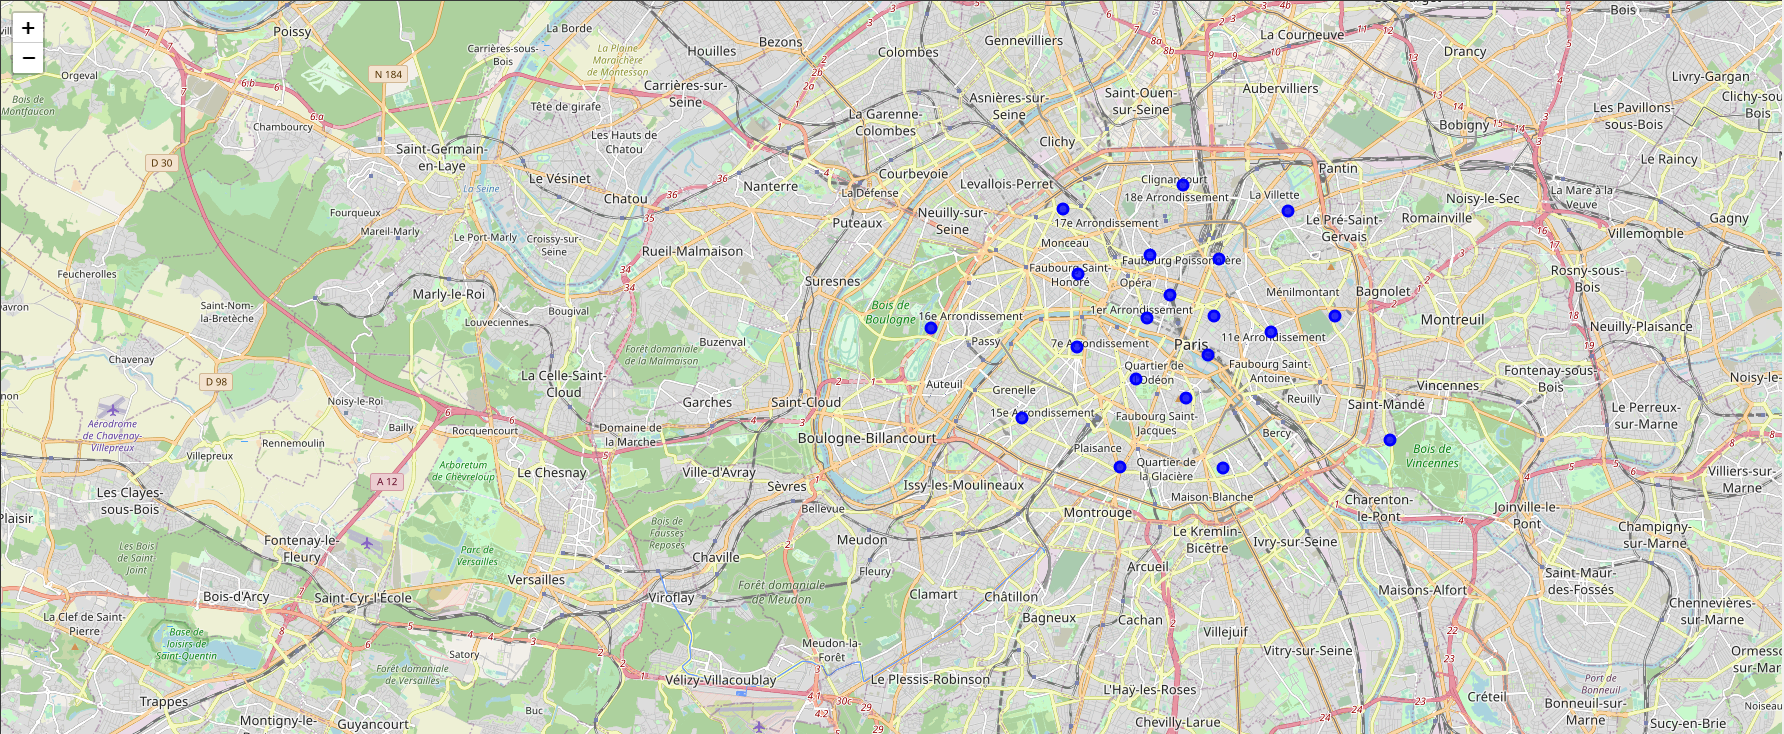



### 4.2 Configure the Foursquare API 

The Foursquare API should be first configured to fetch the necessary data from the API


```
CLIENT_ID = 'NKH5LOIG3E1FIGHVASEZIY42KD5O0YHFKSIBXFWYP5BIYSTF' 
CLIENT_SECRET = 'EJVUHICOHKIE0QQQTJ1JMLIS1HKWOPSXIOLXO0FO5LCWCUSZ'
VERSION = '20190101'
```

Next we will implement a function to fetch nearby venues from the Foursquare API by providing the neighborhoods, latitutes, longitudes, and radisu as parameters.


```
LIMIT=100

def fetchNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues = []
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # Define URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Append results to vunue list
        venues.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    # Create Dataframe
    nearby_venues = pd.DataFrame([item for venue in venues for item in venue])
    nearby_venues.columns = ['Neighbourhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)
```
We can use the above function to fetch nearby venues for each neighborhood in Paris


```
nearby_venues = fetchNearbyVenues(df['nom_comm'], df['Latitude'], df['Longitude'])
nearby_venues.head()
```
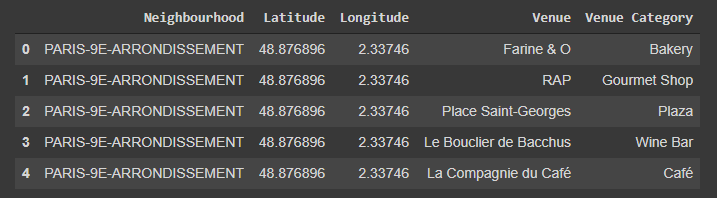






### 4.3 Exploring nearby venues in Paris

```
nearby_venues.groupby('Venue Category').max()
```
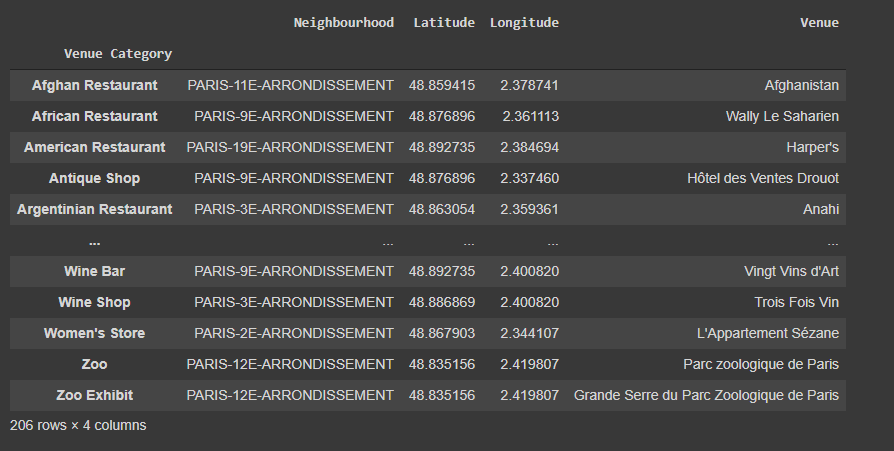

In order to organize venues, we first perform One Hot Encoding. The encoded dataframe will later be used to identify different venue categories and to calculate the top 10 venues in each neighborhood



```
encoded = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")
encoded.head()
```

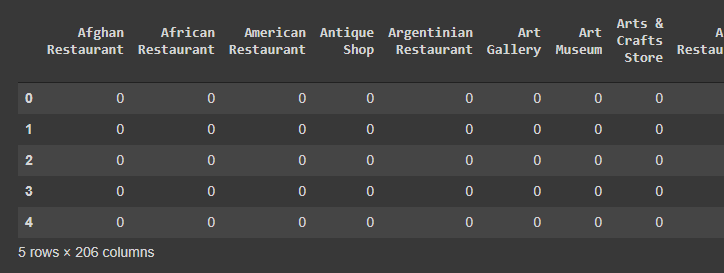




### 4.4 Analyzing the top venues in each Neighborhood

Initially the neighborhoods are added to the encoded dataframe


```
encoded['Neighbourhood'] = nearby_venues['Neighbourhood'] 

encoded_updates = [encoded.columns[-1]] + list(encoded.columns[:-1])
encoded = encoded[encoded_updates]
```

Next, the mean of venue categories are calculated for each neighborhood
```
df_paris = encoded.groupby('Neighbourhood').mean().reset_index()
```

Finally, the venues are sorted from the highers mean to the lowest. We consider the top ten venues for each neighborhood.

```
venue_count = 10

# Dataframe columns (neighborhood and the respective top 10 venues)
columns = ['Neighbourhood']
for index in np.arange(venue_count):
    try:
        columns.append('Venue {}'.format(index+1))
    except:
        columns.append('Venue {}'.format(index+1))

# Function to get the top 10 venues of a neighborhood
def getTopVenues(row, venue_count):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:venue_count]

# create a new dataframe for Paris
top_venues_in_neighborhood = pd.DataFrame(columns=columns)
top_venues_in_neighborhood['Neighbourhood'] = df_paris['Neighbourhood']

for index in np.arange(df_paris.shape[0]):
    top_venues_in_neighborhood.iloc[index, 1:] = getTopVenues(df_paris.iloc[index, :], venue_count)

top_venues_in_neighborhood.head()
```

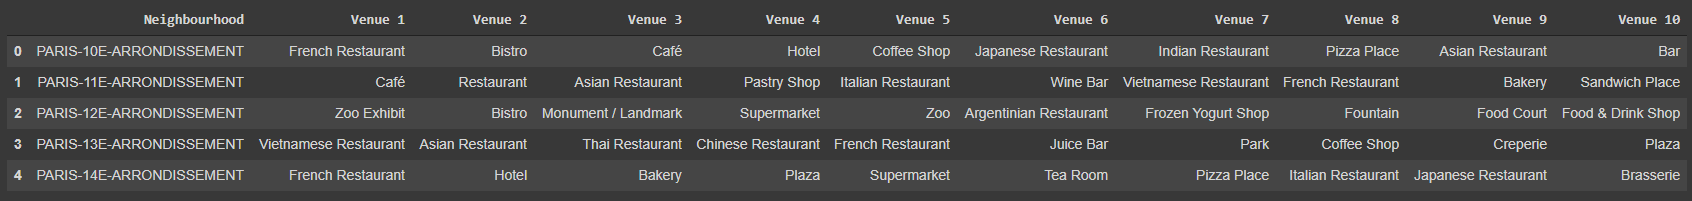



### **5. Cluster Analysis using K means**

In this final step, we will use the results of our implementation phase to cluster the neighborhood in to 5 clusters and analyze each cluster separately.

Paris dataframe will be first clustered into 5 clusters using K means clustering

```
k = 5

clusters = df_paris.drop('Neighbourhood', 1)

paris_k = KMeans(n_clusters=k, random_state=0).fit(clusters)
print(paris_k)
print("Cluster labels: ", paris_k.labels_)
```


 ```
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)
Cluster labels:  [0 0 4 2 1 0 3 1 0 0 0 0 0 0 0 0 0 1 1 0]
```

The cluster labels are then inserted into the Paris dataframe to construct the final complete dataframe

```
top_venues_in_neighborhood.insert(0, 'Cluster Labels', paris_k.labels_ +1)

paris_data = df
paris_data = paris_data.join(top_venues_in_neighborhood.set_index('Neighbourhood'), on='nom_comm')

paris_data.head()
```

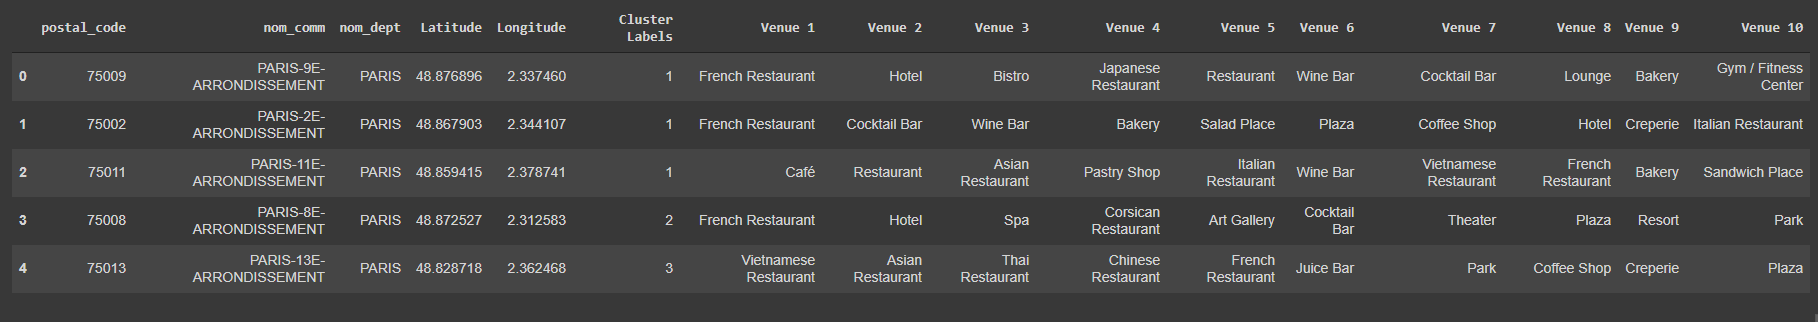



### 5.1 Visualizing the clustered Neighborhoods

```
# Get rid of NaN values
paris_data = paris_data.dropna(subset=['Cluster Labels'])

paris_cluster_map = folium.Map(location=[paris_lat, paris_lng], zoom_start=12)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]

# Set colors
k_colors = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in k_colors]

# Add markers
for lat, lon, poi, cluster in zip(paris_data['Latitude'], paris_data['Longitude'], paris_data['nom_comm'], paris_data['Cluster Labels']):
    label = folium.Popup('Cluster ' + str(int(cluster) +1) + ' ' + str(poi) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.8
        ).add_to(paris_cluster_map)
        
paris_cluster_map
```
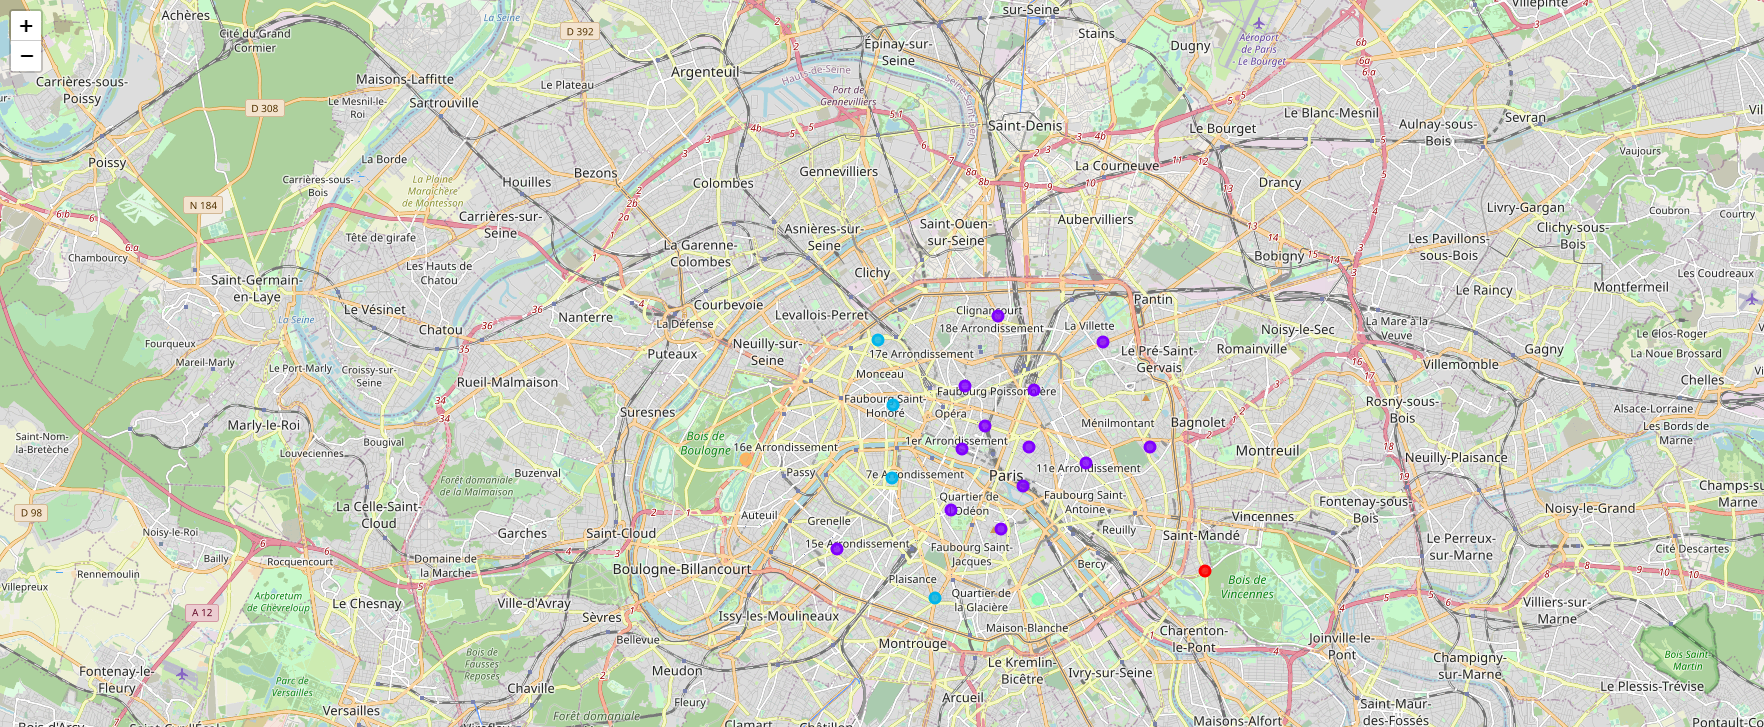

#### 5.2 Exploring the clusters created

Cluster 1

``` paris_data.loc[paris_data['Cluster Labels'] == 1, paris_data.columns[[1] + list(range(5, paris_data.shape[1]))]] ```

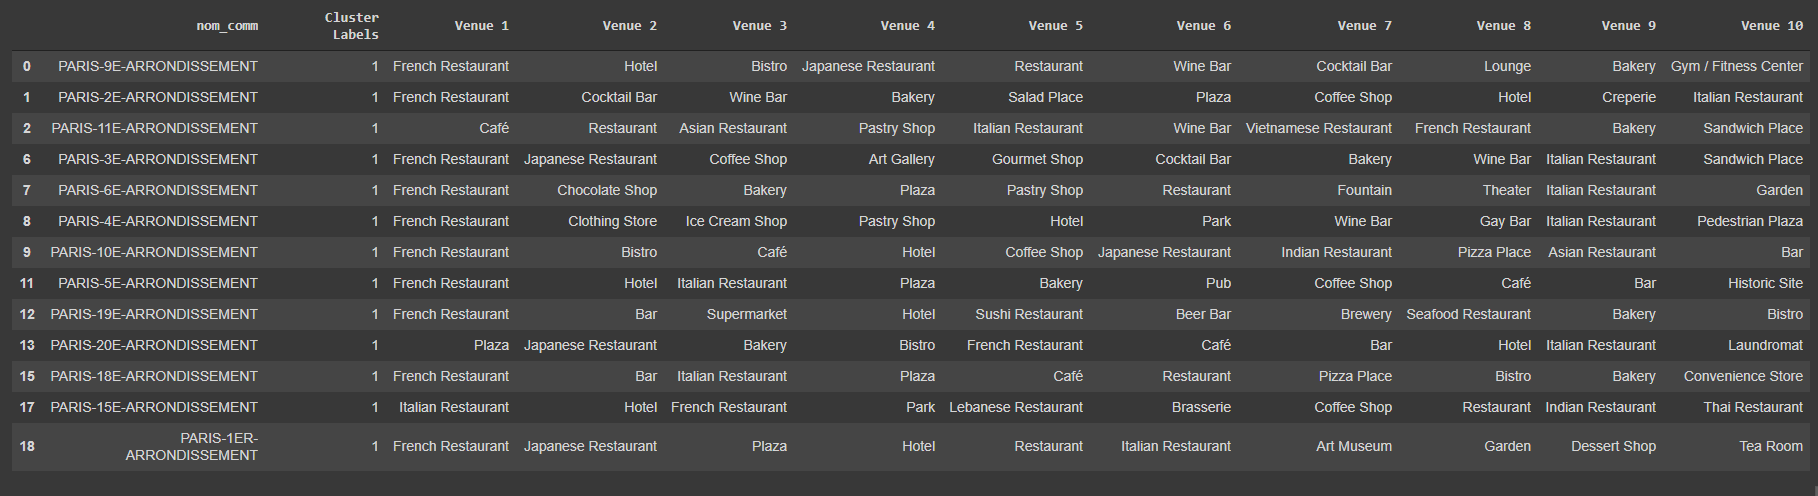

Clsuter 2

``` paris_data.loc[paris_data['Cluster Labels'] == 2, paris_data.columns[[1] + list(range(5, paris_data.shape[1]))]] ```

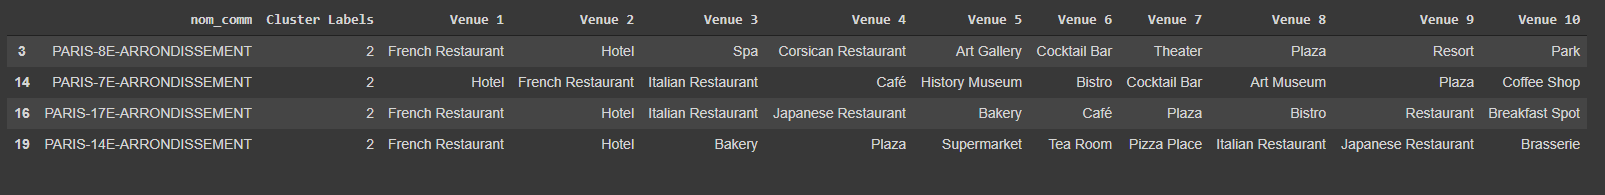

Cluster 3

``` paris_data.loc[paris_data['Cluster Labels'] == 3, paris_data.columns[[1] + list(range(5, paris_data.shape[1]))]] ```

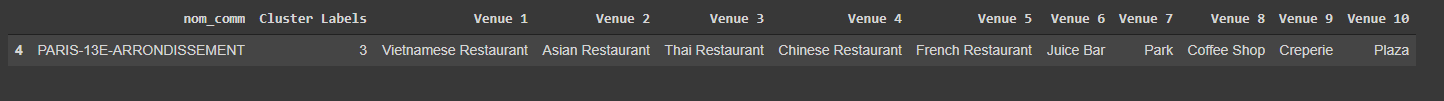

Cluster 4

``` paris_data.loc[paris_data['Cluster Labels'] == 4, paris_data.columns[[1] + list(range(5, paris_data.shape[1]))]] ```

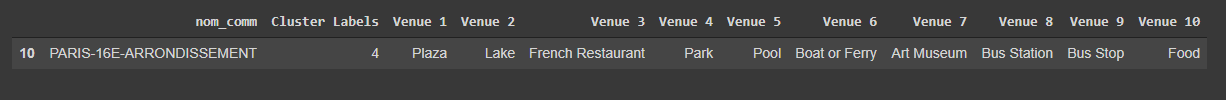

Cluster 5

``` paris_data.loc[paris_data['Cluster Labels'] == 5, paris_data.columns[[1] + list(range(5, paris_data.shape[1]))]] ```

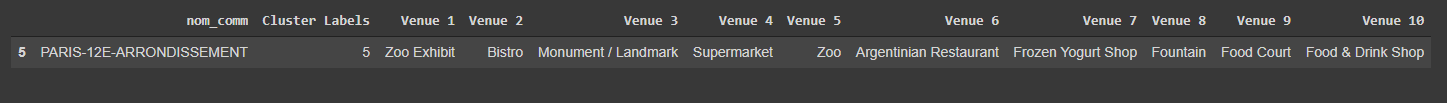

The above clusters describe the Neighborhood that belong to the cluster and venues in the descending order of their popularity. 

### **6. Conclusion**

The intention of this study is to explore the neighborhoods in the city of Paris to guide its tourists with what the city has to offer. Based on the neighborhood, this provides the top 10 places that vistors of Paris can explore from popular landmarks to cafes. 

Based on the ranking of the venue the tourist get the chance to experience the best the city of lights has to offer.